In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.ranking.evaluation import (
    time_based_split,
    compare_models,
    evaluate_item_based_model,
    evaluate_popularity_model
)

df = pd.read_csv("../data/raw/events.csv")
df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [3]:
df.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [4]:
df.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

## Build Interactions DataFrame

In [2]:
# Load interactions data

interactions = pd.read_csv("../data/processed/interactions.csv")
interactions.head(10)

,user_id,item_id,interaction_score,last_interaction_ts
0,0,67045,1.0,2015-09-11 20:55:17.175
1,0,285930,1.0,2015-09-11 20:49:49.439
2,0,357564,1.0,2015-09-11 20:52:39.591
3,1,72028,1.0,2015-08-13 17:46:06.444
4,2,216305,2.0,2015-08-07 18:17:43.170
5,2,259884,1.0,2015-08-07 17:56:52.664
6,2,325215,3.0,2015-08-07 18:20:57.845
7,2,342816,2.0,2015-08-07 18:17:24.375
8,3,385090,1.0,2015-08-01 07:10:35.296
9,4,177677,1.0,2015-09-15 21:24:27.167


In [6]:
# get interactions with specific item_id
test_df = interactions[interactions["item_id"] == 461686]
test_df.head(10)

,user_id,item_id,interaction_score,last_interaction_ts
1381,973,461686,1.0,2015-06-17 15:27:17.567
4317,2857,461686,4.0,2015-08-17 02:24:27.001
4444,2951,461686,1.0,2015-07-10 19:42:16.147
5926,3942,461686,1.0,2015-09-02 18:58:54.378
6237,4162,461686,1.0,2015-09-09 00:05:34.061
7136,4793,461686,1.0,2015-08-18 22:41:13.193
7159,4809,461686,5.0,2015-07-13 19:53:13.206
8177,5544,461686,4.0,2015-08-20 22:08:13.898
8650,5894,461686,1.0,2015-06-06 19:36:27.430
9255,6242,461686,1.0,2015-08-25 22:39:29.827


In [7]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145179 entries, 0 to 2145178
Data columns (total 4 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   item_id              int64  
 2   interaction_score    float64
 3   last_interaction_ts  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 65.5+ MB


In [8]:
interactions.describe()

,user_id,item_id,interaction_score
count,2.145179e+06,2.145179e+06,2.145179e+06
mean,7.020306e+05,2.346137e+05,1.390747e+00
std,4.056801e+05,1.341163e+05,1.636457e+00
min,0.000000e+00,3.000000e+00,1.000000e+00
25%,3.505660e+05,1.176730e+05,1.000000e+00
50%,7.021130e+05,2.354010e+05,1.000000e+00
75%,1.052906e+06,3.503990e+05,1.000000e+00
max,1.407579e+06,4.668670e+05,3.080000e+02


In [9]:
# Number of unique users and items
n_users = interactions['user_id'].nunique()
n_items = interactions['item_id'].nunique()

print(f'Number of unique users: {n_users}')
print(f'Number of unique items: {n_items}')

Number of unique users: 1407580
Number of unique items: 235061


In [10]:
# Number and percentage of users who made a purchase
purchasing_users = interactions.loc[interactions['interaction_score'] >= 5, 'user_id'].nunique()
pct_users_purchased = purchasing_users / n_users * 100

print(purchasing_users)
print(pct_users_purchased)

37349
2.653419343838361


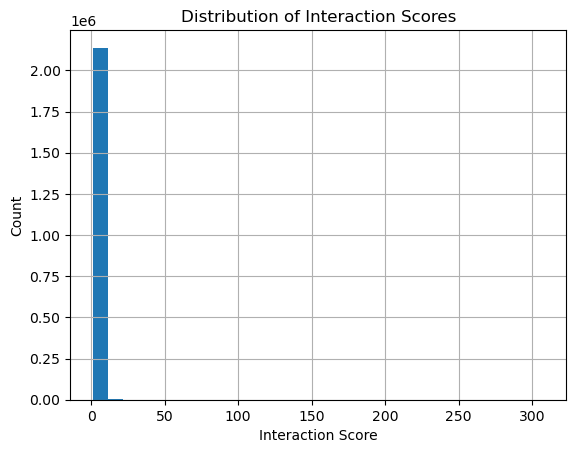

In [11]:
# Distribution of interaction scores
interactions['interaction_score'].hist(bins=30)
plt.title('Distribution of Interaction Scores')
plt.xlabel('Interaction Score')
plt.ylabel('Count')
plt.show()

In [12]:
# Number of users with only one interaction
# Count interactions per user
user_interaction_counts = interactions.groupby("user_id").size()

# Users with exactly one interaction
single_interaction_users = (user_interaction_counts == 1).sum()

single_interaction_users


1119500

In [13]:
# percentage of items that were never purchased
purchased_items = interactions.loc[interactions['interaction_score'] >= 5, 'item_id'].nunique()
n_items = interactions['item_id'].nunique()
pct_items_never_purchased = (n_items - purchased_items) / n_items * 100
print(f'Percentage of items never purchased: {pct_items_never_purchased:.2f}%')

Percentage of items never purchased: 89.55%


## Popularity Baseline (Global)

In [6]:
# time-based train-test split
train, test = time_based_split(interactions)

print(len(train), len(test))

train.info()

1716143 429036
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716143 entries, 0 to 1716142
Data columns (total 4 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   item_id              int64  
 2   interaction_score    float64
 3   last_interaction_ts  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 52.4+ MB


In [4]:
# Sanity checks
# Train is earlier than test
assert train["last_interaction_ts"].max() <= test["last_interaction_ts"].min()

# Correct split ratio
print(len(train) / len(interactions))  # ~0.8

0.799999906767687


#### Precison_Recall@10

In [5]:
# evaluate popularity-based model
results = evaluate_popularity_model(interactions)

print(results)

{'Precision@10': 0.00083676196271941, 'Recall@10': 0.007482368736604862, 'num_test_users': 302356}


In [16]:
# evaluate popularity-based model
results = evaluate_popularity_model(interactions)

print(results)

{'Precision@10': 0.00083676196271941, 'Recall@10': 0.007482368736604862, 'num_test_users': 302356}


## Item-to-Item Candidate Generation

In [ ]:
# evaluate item-based collaborative filtering model
results = evaluate_item_based_model(interactions)

print(results)

Building co-occurrence matrix...
Matrix built: 138131 items with neighbors
{'Precision@10': 0.001194949000515988, 'Recall@10': 0.009576292132919073, 'num_test_users': 302356, 'cold_start_users': 280190, 'items_with_neighbors': 138131}


In [3]:
# compare multiple models
results = compare_models(interactions)

EVALUATING POPULARITY-BASED MODEL

Popularity Model Results:
  Precision@10: 0.00083676196271941
  Recall@10: 0.007482368736604862
  num_test_users: 302356

EVALUATING ITEM-BASED COLLABORATIVE FILTERING MODEL
Building co-occurrence matrix...
Matrix built: 138131 items with neighbors

Item-Based CF Model Results:
  Precision@10: 0.001194949000515988
  Recall@10: 0.009576292132919073
  num_test_users: 302356
  cold_start_users: 280190
  items_with_neighbors: 138131

COMPARISON
Precision Improvement: +0.0004
Recall Improvement: +0.0021


## Ranking Model

In [3]:
# Load training data 

training_df = pd.read_csv("../data/processed/training_data.csv")

training_df.head(10)

,user_id,item_id,item_similarity_score,item_popularity,item_interaction_count,user_history_count,time_since_last_interaction,interaction_type_weight,label
0,829044,60987,0.0,0.025660,0.032864,0,0.0,1.0,1
1,829044,337945,0.0,0.000755,0.000522,0,0.0,0.0,0
2,829044,425936,0.0,0.007547,0.005738,0,0.0,0.0,0
3,829044,389552,0.0,0.003774,0.004695,0,0.0,0.0,0
4,829044,343488,0.0,0.006038,0.005216,0,0.0,0.0,0
5,829044,441900,0.0,0.001132,0.001565,0,0.0,0.0,0
6,829044,368225,0.0,0.001132,0.001565,0,0.0,0.0,0
7,652699,252860,0.0,0.071698,0.088680,0,0.0,1.0,1
8,652699,452271,0.0,0.000755,0.001043,0,0.0,0.0,0
9,652699,339513,0.0,0.000377,0.000522,0,0.0,0.0,0


In [9]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12013001 entries, 0 to 12013000
Data columns (total 7 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   user_id                      int64  
 1   item_id                      int64  
 2   item_similarity_score        float64
 3   item_popularity              float64
 4   time_since_last_interaction  float64
 5   interaction_type_weight      float64
 6   label                        int64  
dtypes: float64(4), int64(3)
memory usage: 641.6 MB


In [10]:
training_df.describe()

,user_id,item_id,item_similarity_score,item_popularity,time_since_last_interaction,interaction_type_weight,label
count,1.201300e+07,1.201300e+07,1.201300e+07,1.201300e+07,1.201300e+07,1.201300e+07,1.201300e+07
mean,7.027728e+05,2.346329e+05,2.291304e-02,5.588644e-02,2.534191e+01,1.978730e-01,1.428571e-01
std,4.055056e+05,1.335933e+05,6.484970e-02,6.031061e-02,1.506564e+02,7.630434e-01,3.499271e-01
min,1.000000e+00,3.000000e+00,0.000000e+00,3.773585e-04,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.516870e+05,1.172830e+05,0.000000e+00,3.207547e-02,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.033380e+05,2.366780e+05,0.000000e+00,4.150943e-02,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.054237e+06,3.496790e+05,0.000000e+00,6.415094e-02,1.406639e-02,0.000000e+00,0.000000e+00
max,1.407579e+06,4.668670e+05,1.000000e+00,1.000000e+00,2.578686e+03,3.080000e+02,1.000000e+00


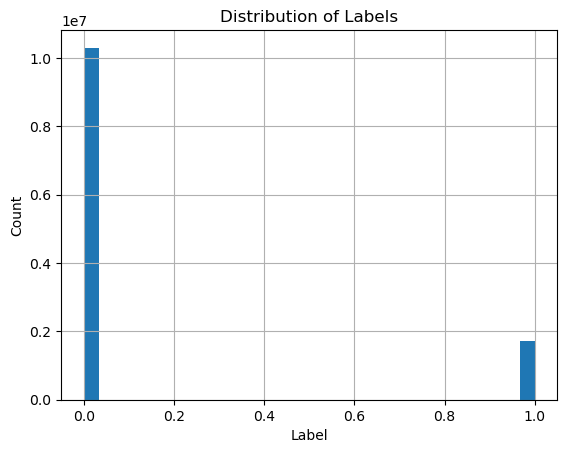

In [12]:
training_df['label'].hist(bins=30)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Logistic Regression Evaluation (Baseline)

In [ ]:
"""
In this iteration, negatives where sampled from 3 sources:
1. Random sampling of items the user has not interacted with
2. Item-item cf 
3. Popularity-based sampling
interaction_type_weight was removed from features but sampled as weights
"""
from src.ranking.train_lr import (
    VAL_FRACTION,
    load_and_split,
    train_lr,
    evaluate_lr,
)

# Load and split data
train_df, val_df = load_and_split("../data/processed/training_data.csv", VAL_FRACTION)

# Train model
model = train_lr(train_df)

# Evaluate model
metrics = evaluate_lr(model, val_df)
print(metrics)

Loaded 12,013,001 rows from ../data/processed/training_data.csv
  Positive ratio: 0.143
  Train: 10,811,700  |  Val: 1,201,301
LogisticRegression trained.
  Coefficients: {'item_similarity_score': 0.216, 'item_popularity': -0.1623, 'time_since_last_interaction': 0.0157}
  Intercept:    -0.0379

Validation metrics:
  AUC:       0.7287
  Log Loss:  0.6828
  Recall:    0.6087
  Precision: 0.4006
{'auc': 0.728722262466512, 'log_loss': 0.682833824667417, 'recall': 0.6086741174962416, 'precision': 0.40064205826851385}


In [ ]:
# training with 2 sources of negatives: popularity & item-item cf
from src.ranking.train_lr import (
    VAL_FRACTION,
    load_and_split,
    train_lr,
    evaluate_lr,
)

# Load and split data
train_df, val_df = load_and_split("../data/processed/training_data.csv", VAL_FRACTION)

# Train model
model = train_lr(train_df)

# Evaluate model
metrics = evaluate_lr(model, val_df)
print(metrics)

Loaded 12,013,001 rows.
LogisticRegression trained.
  Coefficients: {'item_similarity_score': 0.1273, 'item_popularity': 0.9692, 'time_since_last_interaction': -0.0054}
  Intercept:    -1.5812

Validation AUC: 0.7803
Validation Log Loss: 0.3869
None


In [ ]:
# training on 0.2% of the dataset.
# added two extra features: user_interaction_count & item_interaction_count
from src.ranking.train_lr import (
    VAL_FRACTION,
    load_and_split,
    train_lr,
    evaluate_lr,
)

# Load and split data
train_df, val_df = load_and_split("../data/processed/training_data.csv", VAL_FRACTION)

# Train model
model = train_lr(train_df)

# Evaluate model
metrics = evaluate_lr(model, val_df)
print(metrics)

Loaded 2,409,288 rows.
LogisticRegression trained.
  Coefficients: {'item_similarity_score': 0.1222, 'item_popularity': 0.6414, 'item_interaction_count': 0.156, 'user_history_count': 0.0282, 'time_since_last_interaction': -0.0035}
  Intercept:    -1.5819

Validation AUC: 0.7187
Validation Log Loss: 0.3951
None


In [ ]:
# training on full dataset still with the new extra features
from src.ranking.train_lr import (
    VAL_FRACTION,
    load_and_split,
    train_lr,
    evaluate_lr,
)

# Load and split data
train_df, val_df = load_and_split("../data/processed/training_data.csv", VAL_FRACTION)

# Train model
model = train_lr(train_df)

# Evaluate model
metrics = evaluate_lr(model, val_df)
print(metrics)

Loaded 12,013,001 rows.
LogisticRegression trained.
  Coefficients: {'item_similarity_score': 0.1353, 'item_popularity': 0.0571, 'item_interaction_count': 0.9693, 'user_history_count': 0.0273, 'time_since_last_interaction': -0.0036}
  Intercept:    -1.5803

Validation AUC: 0.7850
Validation Log Loss: 0.3829
None


## Xgboost model evaluation

Loaded 12,013,001 rows.
  Positive ratio: 0.143
  Train: 10,811,700 | Val: 1,201,301

Training XGBoost Ranker...
[0]	validation_0-auc:0.54484
[50]	validation_0-auc:0.89570
[100]	validation_0-auc:0.89919
[150]	validation_0-auc:0.89983
[199]	validation_0-auc:0.89997
Training Complete.

FINAL VALIDATION METRICS
  AUC:       0.9000
  Log Loss:  0.1994

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96   1029687
           1       0.92      0.61      0.73    171614

    accuracy                           0.94   1201301
   macro avg       0.93      0.80      0.85   1201301
weighted avg       0.94      0.94      0.93   1201301


Generating Feature Importance Plot...
  Saved plot to artifacts/plots/xgb_feature_importance.png
0.8999674302366375


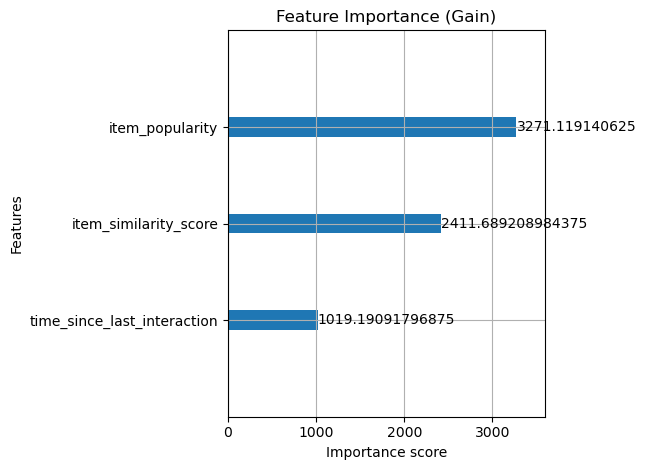

In [ ]:
# training without extra features full dataset
from src.ranking.train_xgb import (
    load_and_prep,
    train_xgboost,
    evaluate_model
)

#load and prep data
X_train, X_val, y_train, y_val, w_train, w_val = load_and_prep("../data/processed/training_data.csv")

# train model
xgb_model = train_xgboost(X_train, y_train, w_train, X_val, y_val)

# evaluate model
xgb_metrics = evaluate_model(xgb_model, X_val, y_val)
print(xgb_metrics)


Loaded 2,409,288 rows.
  Positive ratio: 0.143
  Train: 2,168,359 | Val: 240,929

Training XGBoost Ranker...
[0]	validation_0-auc:0.74140
[50]	validation_0-auc:0.75124
[100]	validation_0-auc:0.75211
[150]	validation_0-auc:0.75258
[199]	validation_0-auc:0.75315
Training Complete.

FINAL VALIDATION METRICS
  AUC:       0.7531
  Log Loss:  0.3559

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92    206511
           1       0.54      0.22      0.31     34418

    accuracy                           0.86    240929
   macro avg       0.71      0.59      0.62    240929
weighted avg       0.83      0.86      0.84    240929


Generating Feature Importance Plot...
0.7531486226008746


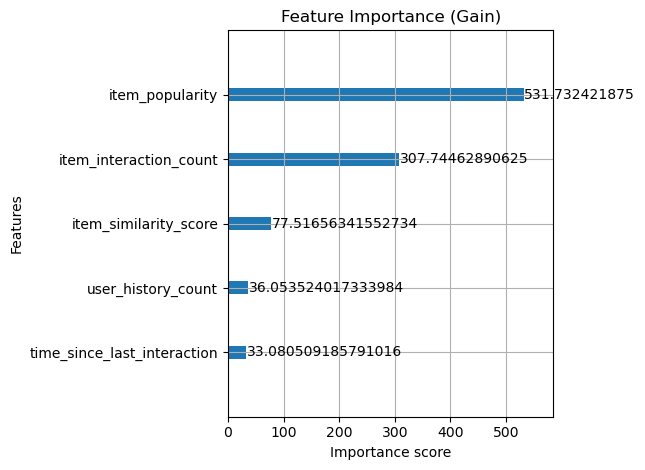

In [ ]:
# training with the extra features on 0.2% of the dataset
from src.ranking.train_xgb import (
    load_and_prep,
    train_xgboost,
    evaluate_model
)

#load and prep data
X_train, X_val, y_train, y_val, w_train, w_val = load_and_prep("../data/processed/training_data.csv")

# train model
xgb_model = train_xgboost(X_train, y_train, w_train, X_val, y_val)

# evaluate model
xgb_metrics = evaluate_model(xgb_model, X_val, y_val)
print(xgb_metrics)

Loaded 12,013,001 rows.
  Positive ratio: 0.143
  Train: 10,811,700 | Val: 1,201,301

Training XGBoost Ranker...
[0]	validation_0-auc:0.81392
[50]	validation_0-auc:0.81937
[100]	validation_0-auc:0.82089
[150]	validation_0-auc:0.82179
[200]	validation_0-auc:0.82221
[250]	validation_0-auc:0.82260
[299]	validation_0-auc:0.82282
Training Complete.

FINAL VALIDATION METRICS
  AUC:       0.8228
  Log Loss:  0.3196

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93   1029687
           1       0.58      0.34      0.43    171614

    accuracy                           0.87   1201301
   macro avg       0.74      0.65      0.68   1201301
weighted avg       0.85      0.87      0.86   1201301


Generating Feature Importance Plot...
0.822821566383804


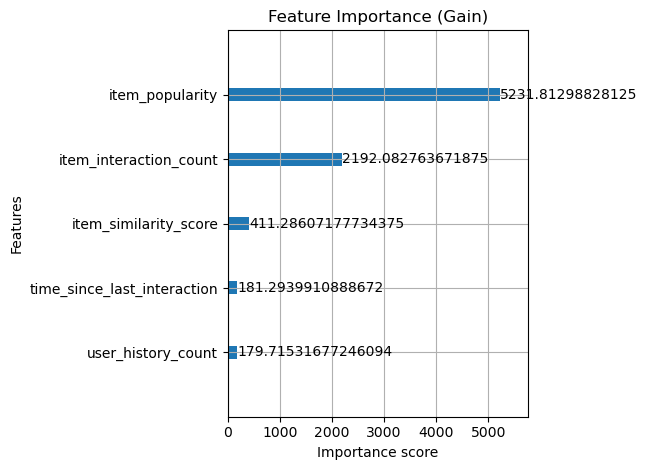

In [ ]:
# training with the extra features on full dataset
from src.ranking.train_xgb import (
    load_and_prep,
    train_xgboost,
    evaluate_model
)

#load and prep data
X_train, X_val, y_train, y_val, w_train, w_val = load_and_prep("../data/processed/training_data.csv")

# train model
xgb_model = train_xgboost(X_train, y_train, w_train, X_val, y_val)

# evaluate model
xgb_metrics = evaluate_model(xgb_model, X_val, y_val)
print(xgb_metrics)

# Comparing Popularity, Item-item & Item-Item + ranking

### Logistic Regression ranker

In [ ]:
# lr ranker trained on dataset without the extra features
from src.ranking.evaluation import compare_models

# compare models
results = compare_models(interactions,"../artifacts/models/lr_ranker.joblib")
print(results)

ModuleNotFoundError: No module named 'src'

In [ ]:
# lr ranker trained on dataset with the extra features
from src.ranking.evaluation import compare_models

# compare models
results = compare_models(interactions,"../artifacts/models/lr_ranker.joblib")
print(results)


 POPULARITY BASELINE

 ITEM-ITEM CF
  Building co-occurrence matrix …
  138,131 items with neighbours

 ITEM-ITEM CF  +  LEARNED RANKER
  Building RankingContext …
Building RankingContext …
  similarity_matrix: 138,131 items
  RankingContext ready.


c:\Users\cjtor\AppData\Local\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\cjtor\AppData\Local\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\cjtor\AppData\Local\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipel

  Scoring 302,356 users...
    scored 1,000/302,356 users …
    scored 2,000/302,356 users …
    scored 3,000/302,356 users …
    scored 4,000/302,356 users …
    scored 5,000/302,356 users …
    scored 6,000/302,356 users …
    scored 7,000/302,356 users …
    scored 8,000/302,356 users …
    scored 9,000/302,356 users …
    scored 10,000/302,356 users …
    scored 11,000/302,356 users …
    scored 12,000/302,356 users …
    scored 13,000/302,356 users …
    scored 14,000/302,356 users …
    scored 15,000/302,356 users …
    scored 16,000/302,356 users …
    scored 17,000/302,356 users …
    scored 18,000/302,356 users …
    scored 19,000/302,356 users …
    scored 20,000/302,356 users …
    scored 21,000/302,356 users …
    scored 22,000/302,356 users …
    scored 23,000/302,356 users …
    scored 24,000/302,356 users …
    scored 25,000/302,356 users …
    scored 26,000/302,356 users …
    scored 27,000/302,356 users …
    scored 28,000/302,356 users …
    scored 29,000/302,356 user

In [ ]:
# xgb ranker trained on dataset with the extra features
from src.ranking.evaluation import compare_models

# compare models
results = compare_models(interactions,"../artifacts/models/xgb_ranker.json")
print(results)


 POPULARITY BASELINE

 ITEM-ITEM CF
  Building co-occurrence matrix …
  138,131 items with neighbours

 ITEM-ITEM CF  +  LEARNED RANKER
  Building RankingContext …
Building RankingContext …
  similarity_matrix: 138,131 items
  RankingContext ready.
  Scoring 302,356 users...
    scored 1,000/302,356 users …
    scored 2,000/302,356 users …
    scored 3,000/302,356 users …
    scored 4,000/302,356 users …
    scored 5,000/302,356 users …
    scored 6,000/302,356 users …
    scored 7,000/302,356 users …
    scored 8,000/302,356 users …
    scored 9,000/302,356 users …
    scored 10,000/302,356 users …
    scored 11,000/302,356 users …
    scored 12,000/302,356 users …
    scored 13,000/302,356 users …
    scored 14,000/302,356 users …
    scored 15,000/302,356 users …
    scored 16,000/302,356 users …
    scored 17,000/302,356 users …
    scored 18,000/302,356 users …
    scored 19,000/302,356 users …
    scored 20,000/302,356 users …
    scored 21,000/302,356 users …
    scored 22,000/